In [68]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

In [69]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

In [75]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

# Define a function to extract features from a list of images
def img_features(feature_image,spatial_size, hist_bins, orient, pix_per_cell, cell_per_block):
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
    return hog_features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# def single_img_features(feature_image, spatial_size,hist_bins, orient, pix_per_cell, cell_per_block):     
#     img_features = []
#     spatial_features = cv2.resize(feature_image, spatial_size).ravel() 
#     img_features.append(spatial_features)
#     hist_features = color_hist(feature_image, nbins=hist_bins)
#     img_features.append(hist_features)
#     hog_features = []
#     for channel in range(feature_image.shape[2]):
#         hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
#     hog_features = np.ravel(hog_features)
#     img_features.append(hog_features)
#     return img_features


def get_vehicle_list():
    images = glob.glob('*vehicles/*/*')
    cars = []
    notcars = []
    for image in images:
        if 'non' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars

In [76]:
cars, notcars = get_vehicle_list()

In [77]:
car_features = extract_features(cars, color_space, 
                        orient, pix_per_cell, 
                        cell_per_block,"ALL")
notcar_features = extract_features(notcars, color_space, 
                        orient, pix_per_cell, 
                        cell_per_block,"ALL")


/Users/boyinzhang/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [78]:
def train(car_features, notcar_features):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)   
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    model = LinearSVC() # Use a linear SVC 
    model.fit(X_train, y_train) # Train the classifier
    print('Test Accuracy of SVC = ', round(model.score(X_test, y_test), 4)) # Check the score of the SVC
    return model

In [79]:
model = train(car_features, notcar_features)

Test Accuracy of SVC =  0.9823


In [150]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, model, orient,
              pix_per_cell, cell_per_block):

    # array of bbox where cars were detected
    bbox = []

    img = img.astype(np.float32)/255

    image = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: image = np.copy(image)

    # rescale image if other than 1.0 scale
    if scale != 1:
        shape = image.shape
        resized_img = cv2.resize(image, (np.int(shape[1]/scale), np.int(shape[0]/scale)))
    else:
        resized_img = image
    ch1 = resized_img[:,:,0]
    ch2 = resized_img[:,:,1]
    ch3 = resized_img[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = model.predict(hog_features.reshape(1, -1))

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return bbox


In [151]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [152]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

In [194]:
from scipy.ndimage.measurements import label
import math
def pipeline(img):

    bbox = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    

    ystart = 400
    ystop = 480
    scale = 1.0
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, 
                           orient, pix_per_cell, cell_per_block))
    
    ystart = 400
    ystop = 500
    scale = 1.2
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, 
                           orient, pix_per_cell, cell_per_block))

    
    ystart = 400
    ystop = 528
    scale = 1.4
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model,
                           orient, pix_per_cell, cell_per_block))

    
    ystart = 400
    ystop = 540
    scale = 1.6
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model,
                           orient, pix_per_cell, cell_per_block))
    
    ystart = 400
    ystop = 560
    scale = 2.0
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, 
                           orient, pix_per_cell, cell_per_block))
    
    ystart = 400
    ystop = 600
    scale = 2.7
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model,
                           orient, pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 660
    scale = 3.5
    bbox.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, model, 
                           orient, pix_per_cell, cell_per_block))

        

    bbox = [item for sublist in bbox for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, bbox)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

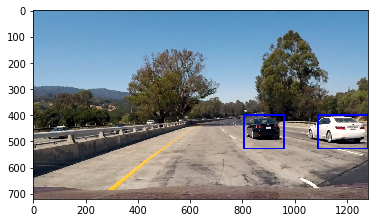

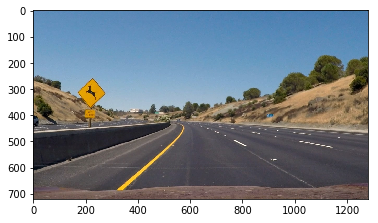

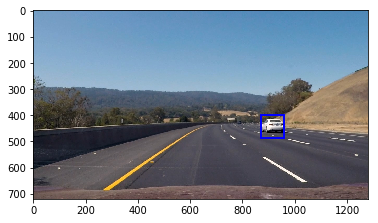

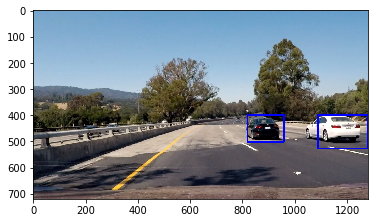

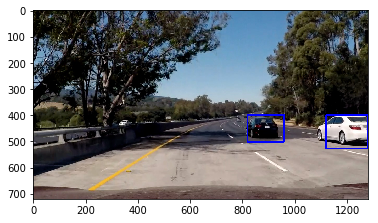

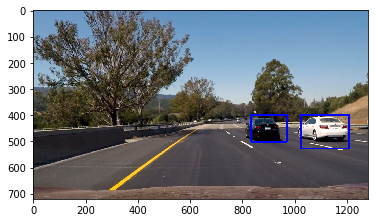

In [195]:
test_images = glob.glob('./test_images/test*.jpg')

for image in test_images:
    img = plt.imread(image)
    out = pipeline(img)
    plt.imshow(out)
    plt.show()

In [ ]:
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
white_output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



 12%|█▏        | 152/1261 [00:42<04:56,  3.73it/s]


 24%|██▍       | 303/1261 [01:25<04:39,  3.43it/s]


 36%|███▌      | 454/1261 [02:08<03:42,  3.63it/s]


 48%|████▊     | 605/1261 [02:51<03:01,  3.61it/s]


 60%|█████▉    | 756/1261 [03:33<02:25,  3.47it/s]


 72%|███████▏  | 907/1261 [04:19<01:53,  3.13it/s]


 84%|████████▍ | 1057/1261 [05:04<00:58,  3.49it/s]


 96%|█████████▌| 1205/1261 [05:46<00:15,  3.54it/s]


 99%|█████████▊| 1243/1261 [05:57<00:05,  3.51it/s]